In [1]:
import pandas as pd
import src.apriori as apriori
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import ast

DATA_DIR_PROC = Path("data/processed")
CAT_VOCAB     = DATA_DIR_PROC / "cat_vocab.parquet"



def baskets_parquet_to_transactions(path_parquet):
    b = pd.read_parquet(path_parquet)
    # sets of items
    return [set(items) for items in b["items"]]


liked_tx  = baskets_parquet_to_transactions("data/processed/baskets_liked_ids.parquet")
hated_tx  = baskets_parquet_to_transactions("data/processed/baskets_hated_ids.parquet")

In [11]:
len(hated_tx), len(liked_tx)

(59993, 208578)

In [2]:
min_support = 0.01
min_conf    = 0.4

print("Applying apriori on LIKED...")
frequent_liked = apriori.apriori_triangular(liked_tx, min_support)
rules_liked    = apriori.generate_rules(frequent_liked, liked_tx, min_conf)
df_rules_liked = pd.DataFrame(rules_liked).sort_values("Lift", ascending=False)
df_rules_liked.to_csv("data/processed/apriori_results/rules_liked.csv", index=False)

print("Applying apriori on HATED...")
frequent_hated = apriori.apriori_triangular(hated_tx, min_support)
rules_hated    = apriori.generate_rules(frequent_hated, hated_tx, min_conf)
df_rules_hated = pd.DataFrame(rules_hated).sort_values("Lift", ascending=False)
df_rules_hated.to_csv("data/processed/apriori_results/rules_hated.csv", index=False)

Applying apriori on LIKED...
Applying apriori on HATED...


In [3]:
frequent_liked[2]

[frozenset({np.int64(43), np.int64(121), np.int64(170)}),
 frozenset({np.int64(104), np.int64(151), np.int64(195)}),
 frozenset({np.int64(83), np.int64(151), np.int64(155)}),
 frozenset({np.int64(4), np.int64(138), np.int64(193)}),
 frozenset({np.int64(19), np.int64(151), np.int64(193)}),
 frozenset({np.int64(4), np.int64(121), np.int64(170)}),
 frozenset({np.int64(4), np.int64(40), np.int64(185)}),
 frozenset({np.int64(19), np.int64(106), np.int64(121)}),
 frozenset({np.int64(40), np.int64(106), np.int64(151)}),
 frozenset({np.int64(121), np.int64(149), np.int64(155)}),
 frozenset({np.int64(43), np.int64(104), np.int64(131)}),
 frozenset({np.int64(54), np.int64(106), np.int64(151)}),
 frozenset({np.int64(4), np.int64(121), np.int64(172)}),
 frozenset({np.int64(3), np.int64(13), np.int64(29)}),
 frozenset({np.int64(4), np.int64(104), np.int64(121)}),
 frozenset({np.int64(54), np.int64(121), np.int64(155)}),
 frozenset({np.int64(4), np.int64(121), np.int64(193)}),
 frozenset({np.int64(4

In [4]:
print("Rules liked lengh:", len(rules_liked))
print("Rules hated length:", len(rules_hated))

Rules liked lengh: 27586
Rules hated length: 43


In [5]:

id2cat_df  = pd.read_parquet(CAT_VOCAB)
id2cat_map = id2cat_df.set_index("cat_id")["simple_category"].to_dict()

def parse_tuple(s):
    s = str(s).strip()
    if not s:
        return tuple()

    # Case 1: "(np.int64(3), np.int64(104), ...)"
    if "np.int64" in s:
        nums = re.findall(r"np\.int64\(\s*(-?\d+)\s*\)", s)
        if nums:
            return tuple(int(n) for n in nums)
        # fall through if regex failed

    # Case 2: normal Python tuple/string representation
    try:
        val = ast.literal_eval(s)   # e.g. "('American (New)', 'Burgers', 'Pizza')"
    except (ValueError, SyntaxError):
        return (s,)

    return tuple(val) if isinstance(val, (list, tuple)) else (val,)


def decode_item(x):
    """
    - If x is an int, map via id2cat_map
    - If it's already a string (liked rules), keep it as is
    """
    if isinstance(x, int):
        return id2cat_map.get(x, f"<UNKNOWN_ID_{x}>")
    return x

def decode_tuple_str(s):
    tup = parse_tuple(s)
    return tuple(decode_item(x) for x in tup)


In [6]:
# Create decoded (human-readable) versions
for df in (df_rules_liked, df_rules_hated):
    df["Antecedent_decoded"] = df["Antecedent"].apply(decode_tuple_str)
    df["Consequent_decoded"] = df["Consequent"].apply(decode_tuple_str)


# save these new dataframes with decoded columns
df_rules_liked.to_csv("data/processed/apriori_results/rules_liked_human.csv", index=False)
df_rules_hated.to_csv("data/processed/apriori_results/rules_hated_human.csv", index=False)

In [7]:
# load the csvs without running the analyis 

df_rules_liked = pd.read_csv("data/processed/apriori_results/rules_liked_human.csv")
df_rules_hated = pd.read_csv("data/processed/apriori_results/rules_hated_human.csv")

In [8]:
len(df_rules_liked["Antecedent_decoded"].iloc[0])

71

In [9]:
df_rules_liked 

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,"(np.int64(3), np.int64(4), np.int64(43), np.in...","(np.int64(19), np.int64(25), np.int64(138))",0.010207,0.402610,16.309093,"('American (New)', 'American (Traditional)', '...","('Breakfast & Brunch', 'Burgers', 'Pizza')"
1,"(np.int64(19), np.int64(25), np.int64(138))","(np.int64(3), np.int64(4), np.int64(43), np.in...",0.010207,0.413478,16.309093,"('Breakfast & Brunch', 'Burgers', 'Pizza')","('American (New)', 'American (Traditional)', '..."
2,"(np.int64(19), np.int64(25), np.int64(104))","(np.int64(3), np.int64(4), np.int64(121), np.i...",0.010126,0.455074,16.189407,"('Breakfast & Brunch', 'Burgers', 'Italian')","('American (New)', 'American (Traditional)', '..."
3,"(np.int64(25), np.int64(43), np.int64(138))","(np.int64(3), np.int64(4), np.int64(19), np.in...",0.010207,0.491345,16.098627,"('Burgers', 'Coffee & Tea', 'Pizza')","('American (New)', 'American (Traditional)', '..."
4,"(np.int64(19), np.int64(25), np.int64(138))","(np.int64(3), np.int64(4), np.int64(121), np.i...",0.011123,0.450573,16.029268,"('Breakfast & Brunch', 'Burgers', 'Pizza')","('American (New)', 'American (Traditional)', '..."
...,...,...,...,...,...,...,...
27581,"(np.int64(138),)","(np.int64(3),)",0.074562,0.421372,1.468585,"('Pizza',)","('American (New)',)"
27582,"(np.int64(40),)","(np.int64(3),)",0.038178,0.421011,1.467326,"('Chinese',)","('American (New)',)"
27583,"(np.int64(43),)","(np.int64(3),)",0.070319,0.408438,1.423506,"('Coffee & Tea',)","('American (New)',)"
27584,"(np.int64(151),)","(np.int64(3),)",0.075286,0.406877,1.418065,"('Sandwiches',)","('American (New)',)"


In [10]:
df_rules_hated

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,"(np.int64(19), np.int64(104))","(np.int64(3),)",0.011735,0.471218,2.295558,"('Breakfast & Brunch', 'Italian')","('American (New)',)"
1,"(np.int64(3), np.int64(83))","(np.int64(4),)",0.010185,0.574248,2.183198,"('American (New)', 'Grocery')","('American (Traditional)',)"
2,"(np.int64(4), np.int64(83))","(np.int64(3),)",0.010185,0.425784,2.074223,"('American (Traditional)', 'Grocery')","('American (New)',)"
3,"(np.int64(104), np.int64(138))","(np.int64(3),)",0.012201,0.408710,1.991048,"('Italian', 'Pizza')","('American (New)',)"
4,"(np.int64(4), np.int64(104))","(np.int64(3),)",0.016985,0.405330,1.974582,"('American (Traditional)', 'Italian')","('American (New)',)"
5,"(np.int64(25), np.int64(104))","(np.int64(4),)",0.011568,0.519073,1.973430,"('Burgers', 'Italian')","('American (Traditional)',)"
6,"(np.int64(25), np.int64(155))","(np.int64(4),)",0.010518,0.518062,1.969589,"('Burgers', 'Seafood')","('American (Traditional)',)"
7,"(np.int64(19), np.int64(138))","(np.int64(3),)",0.011285,0.402736,1.961946,"('Breakfast & Brunch', 'Pizza')","('American (New)',)"
8,"(np.int64(19), np.int64(104))","(np.int64(4),)",0.012701,0.510040,1.939090,"('Breakfast & Brunch', 'Italian')","('American (Traditional)',)"
9,"(np.int64(25), np.int64(138))","(np.int64(4),)",0.014768,0.505708,1.922619,"('Burgers', 'Pizza')","('American (Traditional)',)"


In [35]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 3) & 
               (df_rules_liked["Support"] > 0.024) & (df_rules_liked["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
2504,"(3, 4, 18)","(138,)",0.024080,0.531011,3.227028,"(American (New), American (Traditional), Break...","(Pizza,)"
3327,"(3, 4, 18)","(151,)",0.025261,0.557073,3.222298,"(American (New), American (Traditional), Break...","(Sandwiches,)"
2206,"(3, 4, 18)","(104,)",0.024347,0.536900,3.153072,"(American (New), American (Traditional), Break...","(Italian,)"


In [46]:
df_rules_hated[(df_rules_hated["Antecedent_decoded"].apply(len) == 3) & 
               (df_rules_hated["Support"] > 0.014) & (df_rules_hated["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
463,"(3, 4, 138)","(151,)",0.014228,0.493004,3.405732,"(American (New), American (Traditional), Pizza)","(Sandwiches,)"
599,"(3, 4, 138)","(104,)",0.014201,0.492071,3.383557,"(American (New), American (Traditional), Pizza)","(Italian,)"
641,"(3, 4, 18)","(151,)",0.014255,0.474038,3.274712,"(American (New), American (Traditional), Break...","(Sandwiches,)"
543,"(3, 4, 122)","(104,)",0.014901,0.468671,3.222653,"(American (New), American (Traditional), Mexican)","(Italian,)"
462,"(3, 4, 151)","(138,)",0.014228,0.522233,3.219109,"(American (New), American (Traditional), Sandw...","(Pizza,)"
505,"(3, 4, 18)","(104,)",0.014053,0.467323,3.213388,"(American (New), American (Traditional), Break...","(Italian,)"
584,"(3, 4, 122)","(151,)",0.014686,0.461897,3.190841,"(American (New), American (Traditional), Mexican)","(Sandwiches,)"
598,"(3, 4, 104)","(138,)",0.014201,0.507456,3.128018,"(American (New), American (Traditional), Italian)","(Pizza,)"
408,"(3, 4, 122)","(24,)",0.014040,0.441575,3.099745,"(American (New), American (Traditional), Mexican)","(Burgers,)"


In [48]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 2) & 
               (df_rules_liked["Support"] > 0.024) & (df_rules_liked["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
2503,"(18, 138)","(3, 4)",0.024080,0.448181,4.594052,"(Breakfast & Brunch, Pizza)","(American (New), American (Traditional))"
2205,"(18, 104)","(3, 4)",0.024347,0.441935,4.530025,"(Breakfast & Brunch, Italian)","(American (New), American (Traditional))"
3326,"(18, 151)","(3, 4)",0.025261,0.439068,4.500636,"(Breakfast & Brunch, Sandwiches)","(American (New), American (Traditional))"
2532,"(18, 122)","(3, 4)",0.026006,0.408223,4.184467,"(Breakfast & Brunch, Mexican)","(American (New), American (Traditional))"


In [76]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 2) & (df_rules_liked["Lift"] > 4.5)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
6502,"(138, 169)","(3, 4, 151)",0.010625,0.400686,10.110491,"(Pizza, Specialty Food)","(American (New), American (Traditional), Sandw..."
7252,"(43, 97)","(3, 4, 18)",0.010205,0.415452,9.161708,"(Coffee & Tea, Ice Cream & Frozen Yogurt)","(American (New), American (Traditional), Break..."
6202,"(43, 169)","(3, 4, 18)",0.011006,0.413712,9.123334,"(Coffee & Tea, Specialty Food)","(American (New), American (Traditional), Break..."
5624,"(97, 151)","(3, 4, 18)",0.010727,0.409633,9.033387,"(Ice Cream & Frozen Yogurt, Sandwiches)","(American (New), American (Traditional), Break..."
5272,"(138, 169)","(3, 4, 18)",0.010847,0.409042,9.020352,"(Pizza, Specialty Food)","(American (New), American (Traditional), Break..."
...,...,...,...,...,...,...,...
2398,"(104, 138)","(3, 4)",0.021886,0.446453,4.576342,"(Italian, Pizza)","(American (New), American (Traditional))"
4475,"(104, 154)","(3, 4)",0.020165,0.443736,4.548487,"(Italian, Seafood)","(American (New), American (Traditional))"
2205,"(18, 104)","(3, 4)",0.024347,0.441935,4.530025,"(Breakfast & Brunch, Italian)","(American (New), American (Traditional))"
4901,"(122, 151)","(3, 4)",0.023085,0.440386,4.514147,"(Mexican, Sandwiches)","(American (New), American (Traditional))"


In [50]:
df_rules_hated[(df_rules_hated["Antecedent_decoded"].apply(len) == 2) & 
               (df_rules_hated["Support"] > 0.012) & (df_rules_hated["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
546,"(104, 151)","(3, 4)",0.013313,0.416246,4.800947,"(Italian, Sandwiches)","(American (New), American (Traditional))"
533,"(24, 151)","(3, 4)",0.013124,0.405069,4.672030,"(Burgers, Sandwiches)","(American (New), American (Traditional))"
30,"(3, 67)","(24,)",0.012384,0.436433,3.063647,"(American (New), Fast Food)","(Burgers,)"


In [22]:
df_rules_liked[(df_rules_liked["Support"] > 0.06)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
61,"(138,)","(4,)",0.065841,0.400124,1.530345,"(Pizza,)","(American (Traditional),)"
21,"(104,)","(3,)",0.068136,0.400147,1.515284,"(Italian,)","(American (New),)"


In [23]:
df_rules_hated[(df_rules_hated["Support"] > 0.032)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
10,"(83,)","(4,)",0.032292,0.418601,1.449242,"(Grocery,)","(American (Traditional),)"
13,"(149,)","(4,)",0.032252,0.407206,1.409793,"(Salad,)","(American (Traditional),)"


In [24]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 3) & 
               (df_rules_liked["Support"] > 0.024) & (df_rules_liked["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
2504,"(3, 4, 18)","(138,)",0.024080,0.531011,3.227028,"(American (New), American (Traditional), Break...","(Pizza,)"
3327,"(3, 4, 18)","(151,)",0.025261,0.557073,3.222298,"(American (New), American (Traditional), Break...","(Sandwiches,)"
2206,"(3, 4, 18)","(104,)",0.024347,0.536900,3.153072,"(American (New), American (Traditional), Break...","(Italian,)"


In [25]:
len(df_rules_hated.iloc[0]['Antecedent_decoded'])

2

In [26]:
df_rules_hated[(df_rules_hated["Antecedent_decoded"].apply(len) == 1) & 
               (df_rules_hated["Lift"] > 1.5)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,"(77,)","(3,)",0.014228,0.409849,1.771655,"(Gastropubs,)","(American (New),)"
16,"(182,)","(4,)",0.017243,0.468373,1.621560,"(Tex-Mex,)","(American (Traditional),)"
12,"(121,)","(4,)",0.010984,0.440843,1.526247,"(Mediterranean,)","(American (Traditional),)"
2,"(12,)","(4,)",0.023058,0.437883,1.516002,"(Barbeque,)","(American (Traditional),)"
9,"(77,)","(4,)",0.015170,0.436991,1.512912,"(Gastropubs,)","(American (Traditional),)"
6,"(53,)","(4,)",0.013905,0.436971,1.512843,"(Delis,)","(American (Traditional),)"


In [27]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

In [91]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

# 1) pick a small, interesting subset (example)
subset = (
    df_rules_liked
    [df_rules_liked["Antecedent_decoded"].apply(len) == 3]   # 3 items on LHS
    [df_rules_liked["Support"] >= 0.02]                     # support >= 2%
    .nlargest(50, "Lift")                                   # top 30 by lift
)

# 2) choose an arbitrary transaction count (or len(hated_tx) if you have it)
N = 10000

rules = []

for _, row in subset.iterrows():
    s = float(row["Support"])
    c = float(row["Confidence"])
    L = float(row["Lift"])

    # basic safety guards against divide-by-zero
    if c <= 0 or L <= 0:
        continue

    count_full = max(1, int(round(s * N)))
    count_lhs  = max(1, int(round((s / c) * N)))
    count_rhs  = max(1, int(round((c / L) * N)))

    rule_dict = {
        "lhs": tuple(row["Antecedent_decoded"]),   # e.g. ("American (New)", "Pizza", ...)
        "rhs": tuple(row["Consequent_decoded"]),   # e.g. ("Sandwiches",)
        "count_full": count_full,
        "count_lhs": count_lhs,
        "count_rhs": count_rhs,
        "num_transactions": N,
    }

    rules.append(generate_rule_from_dict(rule_dict))

/tmp/ipykernel_98785/1568101079.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [92]:
import plotly.express as px

df_pc = pd.DataFrame({
    "Antecedent_1": [a[0] for a in subset["Antecedent_decoded"]],
    "Antecedent_2": [a[1] if len(a) > 1 else "(none)" for a in subset["Antecedent_decoded"]],
    "Consequent":   [c[0] for c in subset["Consequent_decoded"]],
    "support":      subset["Support"],
})

fig = px.parallel_categories(
    df_pc,
    dimensions=["Antecedent_2", "Antecedent_1", "Consequent"],
    color="support",
    color_continuous_scale=px.colors.sequential.Blues,
    
)
fig.show()


In [93]:
import plotly.express as px


df_strength = subset.copy()
df_strength["rule_str"] = df_strength["Antecedent_decoded"].astype(str) + " → " + df_strength["Consequent_decoded"].astype(str)

fig_strength = px.scatter(
    df_strength,
    x="Support",
    y="Confidence",
    color="Lift",          # strength-ish
    size="Support",        # bigger bubbles = more support
    hover_name="rule_str",
    labels={
        "Support": "Support",
        "Confidence": "Confidence",
        "Lift": "Lift",
    },
    title="Rule strength: Support vs Confidence (color = Lift)"
)

fig_strength.show()


In [94]:
import pandas as pd
import plotly.express as px

subset_hated = df_rules_hated[
    (df_rules_hated["Support"] > 0.02) &
    (df_rules_hated["Lift"] > 2)
]

df_pc_hated = pd.DataFrame({
    "Antecedent_1": [a[0] for a in subset_hated["Antecedent_decoded"]],
    "Antecedent_2": [a[1] if len(a) > 1 else "(none)" 
                     for a in subset_hated["Antecedent_decoded"]],
    "Consequent":   [c[0] for c in subset_hated["Consequent_decoded"]],
    "support":      subset_hated["Support"],
})

fig_hated = px.parallel_categories(
    df_pc_hated,
    dimensions=["Antecedent_2", "Antecedent_1", "Consequent"],
    color="support",
    # 🔴 change to a red scale instead of Blues
    color_continuous_scale=px.colors.sequential.Reds,
)

fig_hated.show()


In [65]:
import pandas as pd

def basket_summary(transactions):
    n_tx = len(transactions)
    items = sorted({i for t in transactions for i in t})
    n_items = len(items)
    avg_size = sum(len(t) for t in transactions) / n_tx
    return pd.DataFrame({
        "Transactions": [n_tx],
        "Unique items": [n_items],
        "Avg basket size": [avg_size],
    })

summary_liked = basket_summary(liked_tx)
summary_hated = basket_summary(hated_tx)

print("LIKED:")
print(summary_liked)
print("\nHATED:")
print(summary_hated)


LIKED:
   Transactions  Unique items  Avg basket size
0        176000           196         4.778256

HATED:
   Transactions  Unique items  Avg basket size
0         74290           193          3.99226


In [126]:
def top_rules(df_rules, k=10, sort_by="Lift"):
    df = df_rules.copy()
    df["Antecedent"] = df["Antecedent"].apply(lambda x: ", ".join(map(str, x)))
    df["Consequent"] = df["Consequent"].apply(lambda x: ", ".join(map(str, x)))
    df["Support (%)"] = (df["Support"] * 100).round(2)
    df["Confidence (%)"] = (df["Confidence"] * 100).round(2)
    df["Lift"] = df["Lift"].round(3)
    cols = ["Antecedent", "Consequent", "Support (%)", "Confidence (%)", "Lift"]
    return df.sort_values(sort_by, ascending=False)[cols].head(k)

top_liked = top_rules(df_rules_liked, k=30, sort_by="Lift")
top_hated = top_rules(df_rules_hated, k=30, sort_by="Lift")

print("=== LIKED: Top 10 rules by lift ===")
print(top_liked.to_string(index=False))

print("\n=== HATED: Top 10 rules by lift ===")
print(top_hated.to_string(index=False))

=== LIKED: Top 10 rules by lift ===
                                                                                                                           Antecedent                                                                                                                      Consequent  Support (%)  Confidence (%)   Lift
         (, n, p, ., i, n, t, 6, 4, (, 3, ), ,,  , n, p, ., i, n, t, 6, 4, (, 2, 4, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 3, 8, ), ) (, n, p, ., i, n, t, 6, 4, (, 4, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 2, 2, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 5, 1, ), )         1.00           44.53 14.219
         (, n, p, ., i, n, t, 6, 4, (, 3, ), ,,  , n, p, ., i, n, t, 6, 4, (, 2, 4, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 5, 1, ), )    (, n, p, ., i, n, t, 6, 4, (, 4, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 8, ), ,,  , n, p, ., i, n, t, 6, 4, (, 1, 3, 8, ), )         1.04           44.37 13.710
         (, n, p, ., i, n, t, 6, 4, (, 4, ), ,,  , n, p, ., i, n, t, 6

/tmp/ipykernel_9459/2908551945.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


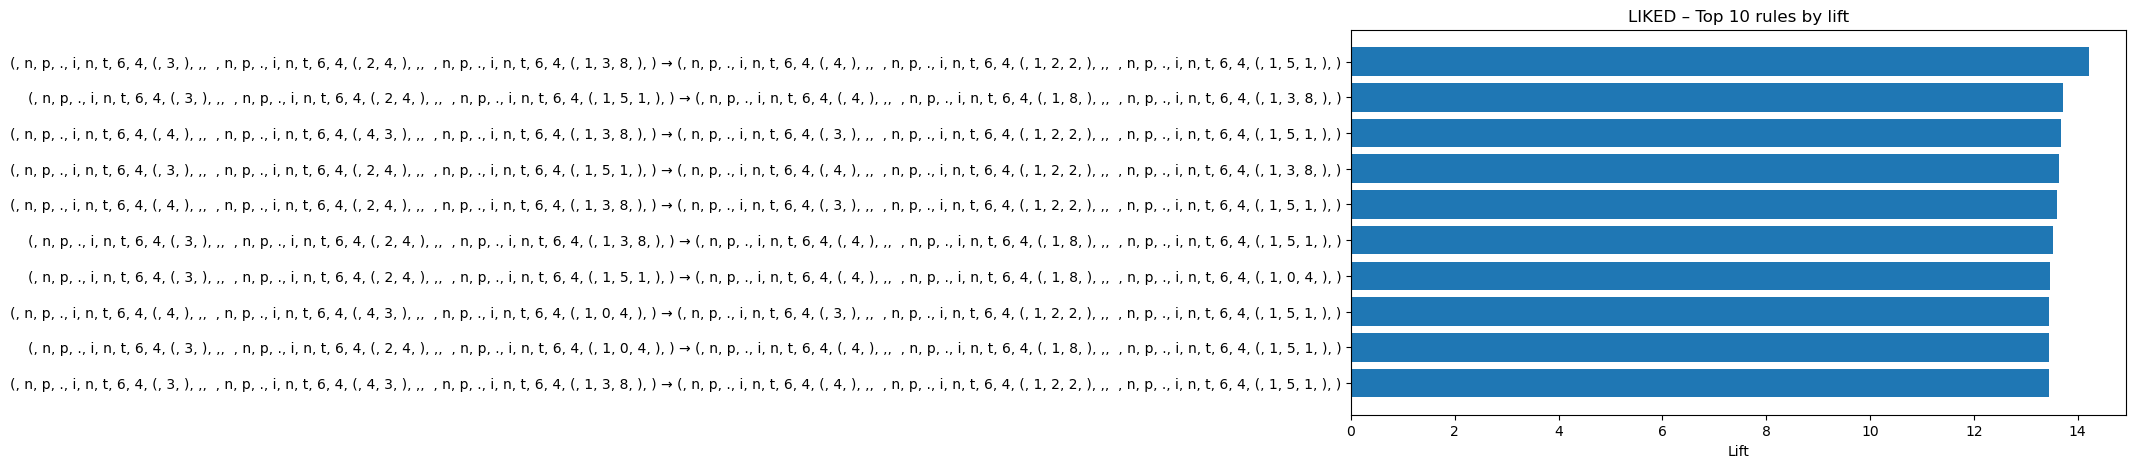

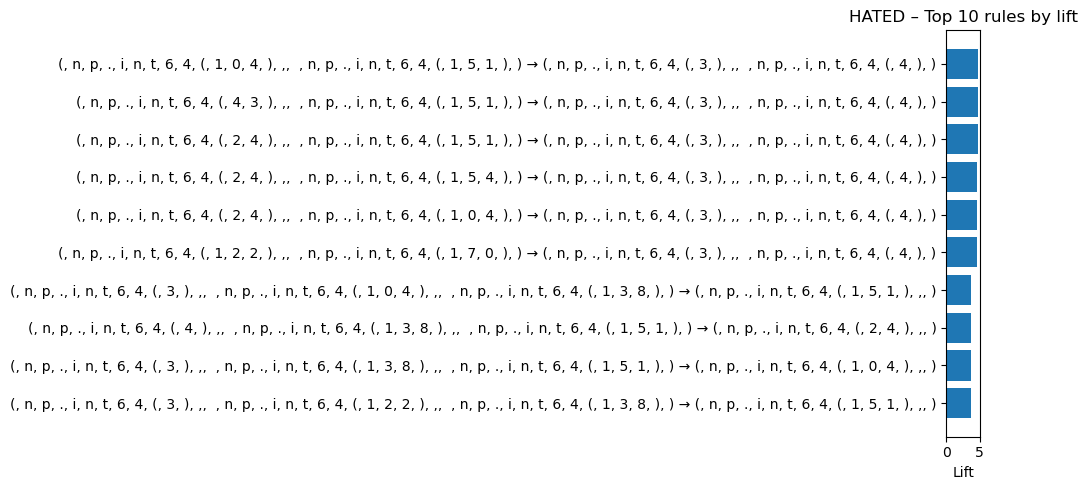

In [38]:
def plot_top_rules(df_rules, k=10, metric="Lift", title="Top rules"):
    df = df_rules.copy()
    df = df.sort_values(metric, ascending=False).head(k)
    labels = [
        f"{', '.join(map(str,a))} → {', '.join(map(str,c))}"
        for a, c in zip(df["Antecedent"], df["Consequent"])
    ]
    values = df[metric]

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(df)), values)
    plt.yticks(range(len(df)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel(metric)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_rules(df_rules_liked, k=10, metric="Lift", title="LIKED – Top 10 rules by lift")
plot_top_rules(df_rules_hated, k=10, metric="Lift", title="HATED – Top 10 rules by lift")


In [103]:
print(df_rules_liked[['Support', 'Confidence', 'Lift']].describe())

strong_liked = df_rules_liked[(df_rules_liked['Lift'] > 2) & 
                               (df_rules_liked['Confidence'] > 0.6)]
print(strong_liked[['Antecedent', 'Consequent', 'Confidence', 'Lift']])

           Support   Confidence         Lift
count  8411.000000  8411.000000  8411.000000
mean      0.012977     0.590129     4.822442
std       0.003883     0.125951     2.443429
min       0.010000     0.400000     1.515284
25%       0.010756     0.481662     3.020936
50%       0.011665     0.580500     3.663252
75%       0.013653     0.680199     6.660879
max       0.068136     0.907426    14.218977
                                             Antecedent  \
284   (np.int64(4), np.int64(24), np.int64(122), np....   
285   (np.int64(4), np.int64(18), np.int64(24), np.i...   
295   (np.int64(3), np.int64(24), np.int64(122), np....   
299   (np.int64(4), np.int64(43), np.int64(104), np....   
303   (np.int64(18), np.int64(104), np.int64(122), n...   
...                                                 ...   
8237                     (np.int64(138), np.int64(154))   
8238                     (np.int64(138), np.int64(151))   
8240                     (np.int64(104), np.int64(138))   
8241 

TypeError: 'module' object is not callable

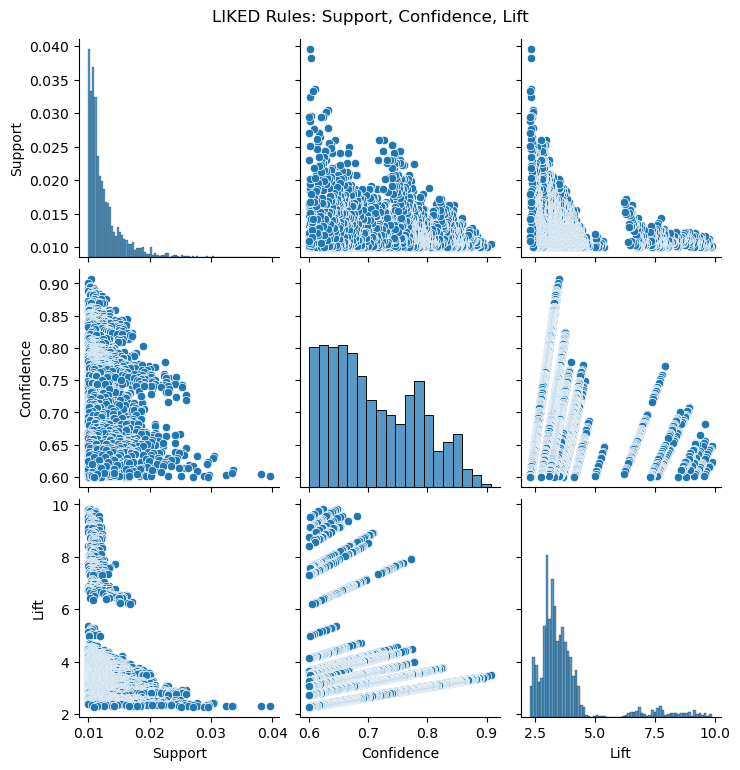

In [ ]:
sns(strong_liked[["Support","Confidence","Lift"]])
plt.suptitle("LIKED Rules: Support, Confidence, Lift", y=1.02)
plt.show()